In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
from sympy import init_printing
init_printing()
from celmech import Poincare,PoincareHamiltonian
from celmech.nbody_simulation_utilities import align_simulation, set_timestep, get_simarchive_integration_results

from celmech.secular import LaplaceLagrangeSystem, SecularSystemSimulation
import rebound as rb
COMPARE = False # Set true to compare numerical results from operator to sympy

# Reference sim

In [45]:
np.random.seed(0)
scale=0.05
sim = rb.Simulation()
sim.add(m=1)
for i in range(1,4):
    sim.add(m=i * 1e-5 , a = 2**i, 
            e = np.random.rayleigh(scale),
            inc = np.random.rayleigh(scale),
            l = 'uniform',
            pomega = 'uniform',
            Omega = 'uniform'
           )
sim.move_to_com()
align_simulation(sim)
sim.integrator = 'whfast'
set_timestep(sim,1/20.)
sim.ri_whfast.safe_mode=0
sim.simulationarchive_snapshot('./sa_secular.bin')

# Functions to get Nbody, secular simulation, and laplace lagrange solution

In [42]:
def get_sim():
    sa  = rb.SimulationArchive('./sa_secular.bin')
    sim = sa[0]
    return sim

def get_sec_sim(dtFraction=1/100):
    sim = get_sim()
    pvars = Poincare.from_Simulation(sim)
    sec_sim = SecularSystemSimulation(state=pvars, dtFraction=dtFraction, max_order=4, DFOp_kwargs={'rtol':1e-10})
    return sec_sim

def get_laplag_sim():
    sim = get_sim()
    pvars = Poincare.from_Simulation(sim)
    llsys = LaplaceLagrangeSystem.from_Poincare(pvars)
    return llsys

# Integration

## Numerical secular model

In [4]:
P1 = sim.particles[1].P
Tfin = 1e6*P1 # million orbits
N = 200 # outputs
T = np.linspace(0,Tfin,N)

In [19]:
def run_secular_sim(sec_sim,times, corrector=False):
    N = len(times)
    eccN,incN = np.zeros((2,sec_sim.state.N - 1,N))
    Eerr = np.zeros(N)
    AMDerr = np.zeros(N)
    timesDone = np.zeros(N)
    E0 = sec_sim.calculate_energy()
    AMD0 = sec_sim.calculate_AMD()
    for i,time in enumerate(times):
        sec_sim.integrate(time, corrector=corrector)
        timesDone[i] = sec_sim.t
        E = sec_sim.calculate_energy()
        AMD = sec_sim.calculate_AMD()
        Eerr[i] = np.abs((E-E0)/E0)
        AMDerr[i] = np.abs((AMD-AMD0)/AMD0)
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
    return timesDone, Eerr, AMDerr, eccN, incN

In [54]:
sec_sim = get_sec_sim(dtFraction=1e-2)
%time times,Eerr,AMDerr,eccN,incN = run_secular_sim(sec_sim,T)

CPU times: user 1.07 s, sys: 34.3 ms, total: 1.1 s
Wall time: 869 ms


In [21]:
T = np.linspace(0,Tfin,N)
sec_sim = get_sec_sim(dtFraction=1e-2)
%time times,EerrC,AMDerrC,eccNC,incNC = run_secular_sim(sec_sim,T, corrector=True)

CPU times: user 13.4 s, sys: 1.14 s, total: 14.5 s
Wall time: 4.87 s


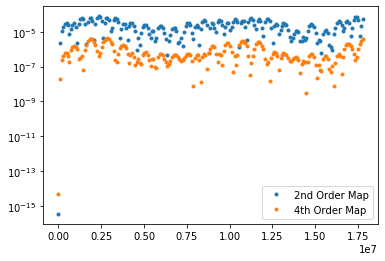

In [22]:
fig, ax = plt.subplots()
ax.plot(times, Eerr, '.', label='2nd Order Map')
ax.plot(times, EerrC, '.', label='4th Order Map')
ax.set_yscale('log')
ax.legend()

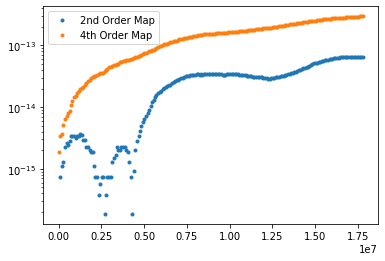

In [23]:
fig, ax = plt.subplots()
ax.plot(times, AMDerr, '.', label='2nd Order Map')
ax.plot(times, AMDerrC, '.', label='4th Order Map')
ax.set_yscale('log')
ax.legend()

## $N$-body

In [48]:
sim = get_sim()
sim.automateSimulationArchive('sa_secular.bin',interval=times[1],deletefile=True)
%time sim.integrate(times[-1])

CPU times: user 12.2 s, sys: 33.8 ms, total: 12.2 s
Wall time: 12.7 s


In [49]:
sa = rb.SimulationArchive('sa_secular.bin')
nbody_results = get_simarchive_integration_results(sa)

## Laplace-Lagrange solution

In [51]:
llsys = get_laplag_sim()
llsoln = llsys.secular_solution(times)

## Comparison

In [52]:
Tsec = llsys.Tsec

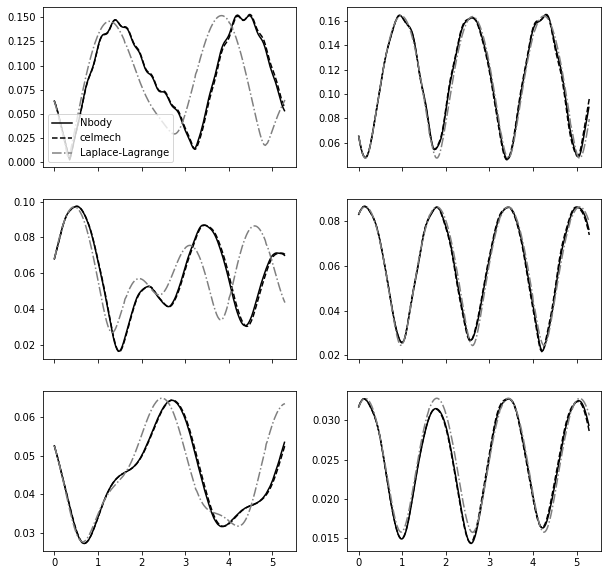

In [55]:
fig,ax = plt.subplots(3,2,figsize=(10,10),sharex=True)
for i in range(3):
    ax[i,0].plot(nbody_results['time']/Tsec,nbody_results['e'][i],color='k', label='Nbody')
    ax[i,0].plot(times/Tsec,eccN[i],'--',color='k', label='celmech')
    ax[i,0].plot(times/Tsec,llsoln['e'][i],ls='-.',color='gray', label='Laplace-Lagrange')
    
    ax[i,1].plot(nbody_results['time']/Tsec,nbody_results['inc'][i],color='k')
    ax[i,1].plot(times/Tsec,incN[i],'--',color='k')
    ax[i,1].plot(times/Tsec,llsoln['inc'][i],ls='-.',color='gray')
    
ax[0,0].legend()

# Scalings

In [10]:
%%time
Ndts = 4
dts = np.logspace(-2, -4, Ndts)
Eerrs = np.zeros(Ndts)
for i, dt in enumerate(dts):
    sec_sim = get_sec_sim(dtFraction=dt)
    times,Eerr,AMDerr,eccN,incN = run_secular_sim(sec_sim,T)
    Eerrs[i] = np.median(Eerr)

CPU times: user 1min 44s, sys: 396 ms, total: 1min 44s
Wall time: 1min 42s


In [11]:
%%time
Ndts = 4
dts = np.logspace(-2, -4, Ndts)
EerrsC = np.zeros(Ndts)
for i, dt in enumerate(dts):
    sec_sim = get_sec_sim(dtFraction=dt)
    times,EerrC,AMDerrC,eccNC,incNC = run_secular_sim(sec_sim,T, corrector=True)
    EerrsC[i] = np.median(EerrC)

CPU times: user 3min 50s, sys: 15.1 s, total: 4min 5s
Wall time: 2min


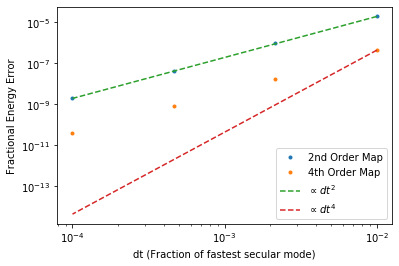

In [12]:
fig, ax = plt.subplots()
ax.plot(dts, Eerrs, '.', label='2nd Order Map')
ax.plot(dts, EerrsC, '.', label='4th Order Map')
ax.plot(dts, Eerrs[0]*(dts/dts[0])**2, '--', label=r'$\propto dt^2$')
ax.plot(dts, EerrsC[0]*(dts/dts[0])**4, '--', label=r'$\propto dt^4$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('dt (Fraction of fastest secular mode)')
ax.set_ylabel('Fractional Energy Error')
ax.legend()